<a href="https://colab.research.google.com/github/lylybell12/FairyTalesAnalysis/blob/main/AutomaticThresholdingPlantStack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
pip install -U scikit-image

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import glob

%matplotlib inline

In [76]:
import skimage.io

In [77]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [78]:
!ls "/content/drive/MyDrive/Colab_Notebooks/SULI2022/Root_photography/"

plantStack.tif	Root_Image_Dataset_1	   Root_Image_Dataset_1_segm
Readme.gdoc	Root_Image_Dataset_1_RSML


In [79]:
path = "/content/drive/MyDrive/Colab_Notebooks/SULI2022/Root_photography/Root_Image_Dataset_1/*.*"

len(glob.glob(path))

1665

## Single Run Try_all_thresholds

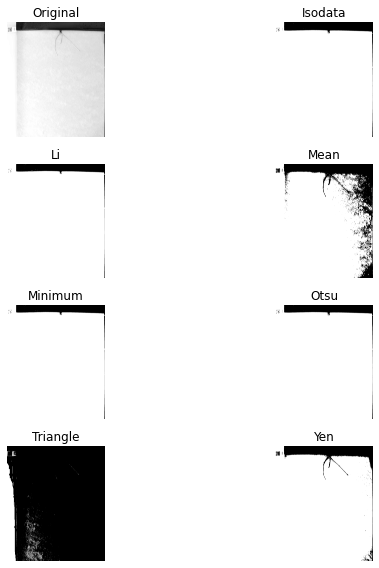

In [82]:
import cv2
import numpy as np
from skimage import segmentation
from google.colab.patches import cv2_imshow
from skimage import data
from skimage.filters import try_all_threshold
from skimage.restoration import denoise_bilateral

file = '/content/drive/MyDrive/Colab_Notebooks/SULI2022/Root_photography/Root_Image_Dataset_1/50_711.jpg'

# read the original image, converting to grayscale on the fly
img = skimage.io.imread(fname=file)

#extracting red channel
img = img[:,:,2] 

# blur before thresholding
blurred_img = skimage.filters.median(img)

#blurred_img = denoise_bilateral(img)


fig, ax = try_all_threshold(blurred_img, figsize=(10, 8), verbose=False)
plt.show()


#boarder cleaner
#clean_images = segmentation.clear_border(binary_mask)

from matplotlib import pyplot as plt

#plt.imshow(blurred_img, cmap = 'gray')
#plt.imshow(binary_mask, cmap = 'gray')
#plt.imshow(clean_images, cmap = 'gray')
#cv2_imshow(res)
#cv2_imshow(clean_images)


## Single Run w/ Li Threshold and Median Blur

A high-pass filter will retain the smaller details in an image, filtering out the larger ones. A low-pass filter retains the larger features, analogous to what’s left behind by a physical filter mesh (gaussian filter). High- and low-pass, here, refer to high and low spatial frequencies in the image.

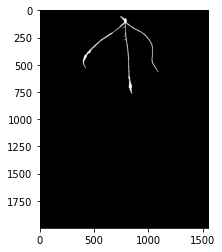

In [83]:
import cv2
import numpy as np
from skimage import segmentation
from google.colab.patches import cv2_imshow
from skimage import data
from skimage.filters import try_all_threshold

file = '/content/drive/MyDrive/Sample/1_4.jpg'

# read the original image, converting to grayscale on the fly
img = cv2.imread(file)

#extracting red channel
img = img[:,:,2] 

#crop image used for labeling
crop_img = img[0:1999, 155:1702]

# median blur before thresholding
blurred_img = skimage.filters.median(img)

# perform automatic thresholding to produce a binary image
t = skimage.filters.threshold_li(blurred_img)
binary_mask = blurred_img > t

#boarder cleaner
clean_image = segmentation.clear_border(binary_mask)

#crop image
final_image = clean_image[0:1999, 155:1702]

from matplotlib import pyplot as plt

#plt.imshow(blurred_img, cmap = 'gray')
#plt.imshow(binary_mask, cmap = 'gray')
plt.imshow(final_image, cmap = 'gray')


In [84]:
type(final_image)

numpy.ndarray

### Labeling Images

array([0, 1, 2], dtype=int32)

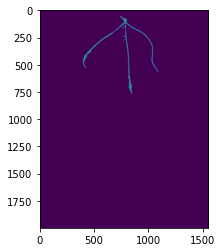

In [85]:
#label connected regions of an integer array using measure.label
#label each connected entity as one object
from skimage import measure

label_image = measure.label(final_image, connectivity = crop_img.ndim)
plt.imshow(label_image)
np.unique(label_image)

In [10]:
import plotly.express as px
import numpy as np
fig = px.imshow(label_image)
fig.show()

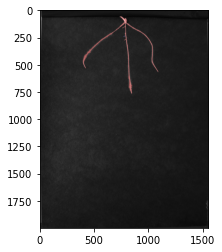

In [11]:
#return an rgb image where color based labels are painted over the image using label2rgb
#the white border doesnt effect the results so we can set image = img
from skimage.color import label2rgb

image_label_overlay = label2rgb(label_image, image = crop_img)
plt.imshow(image_label_overlay)


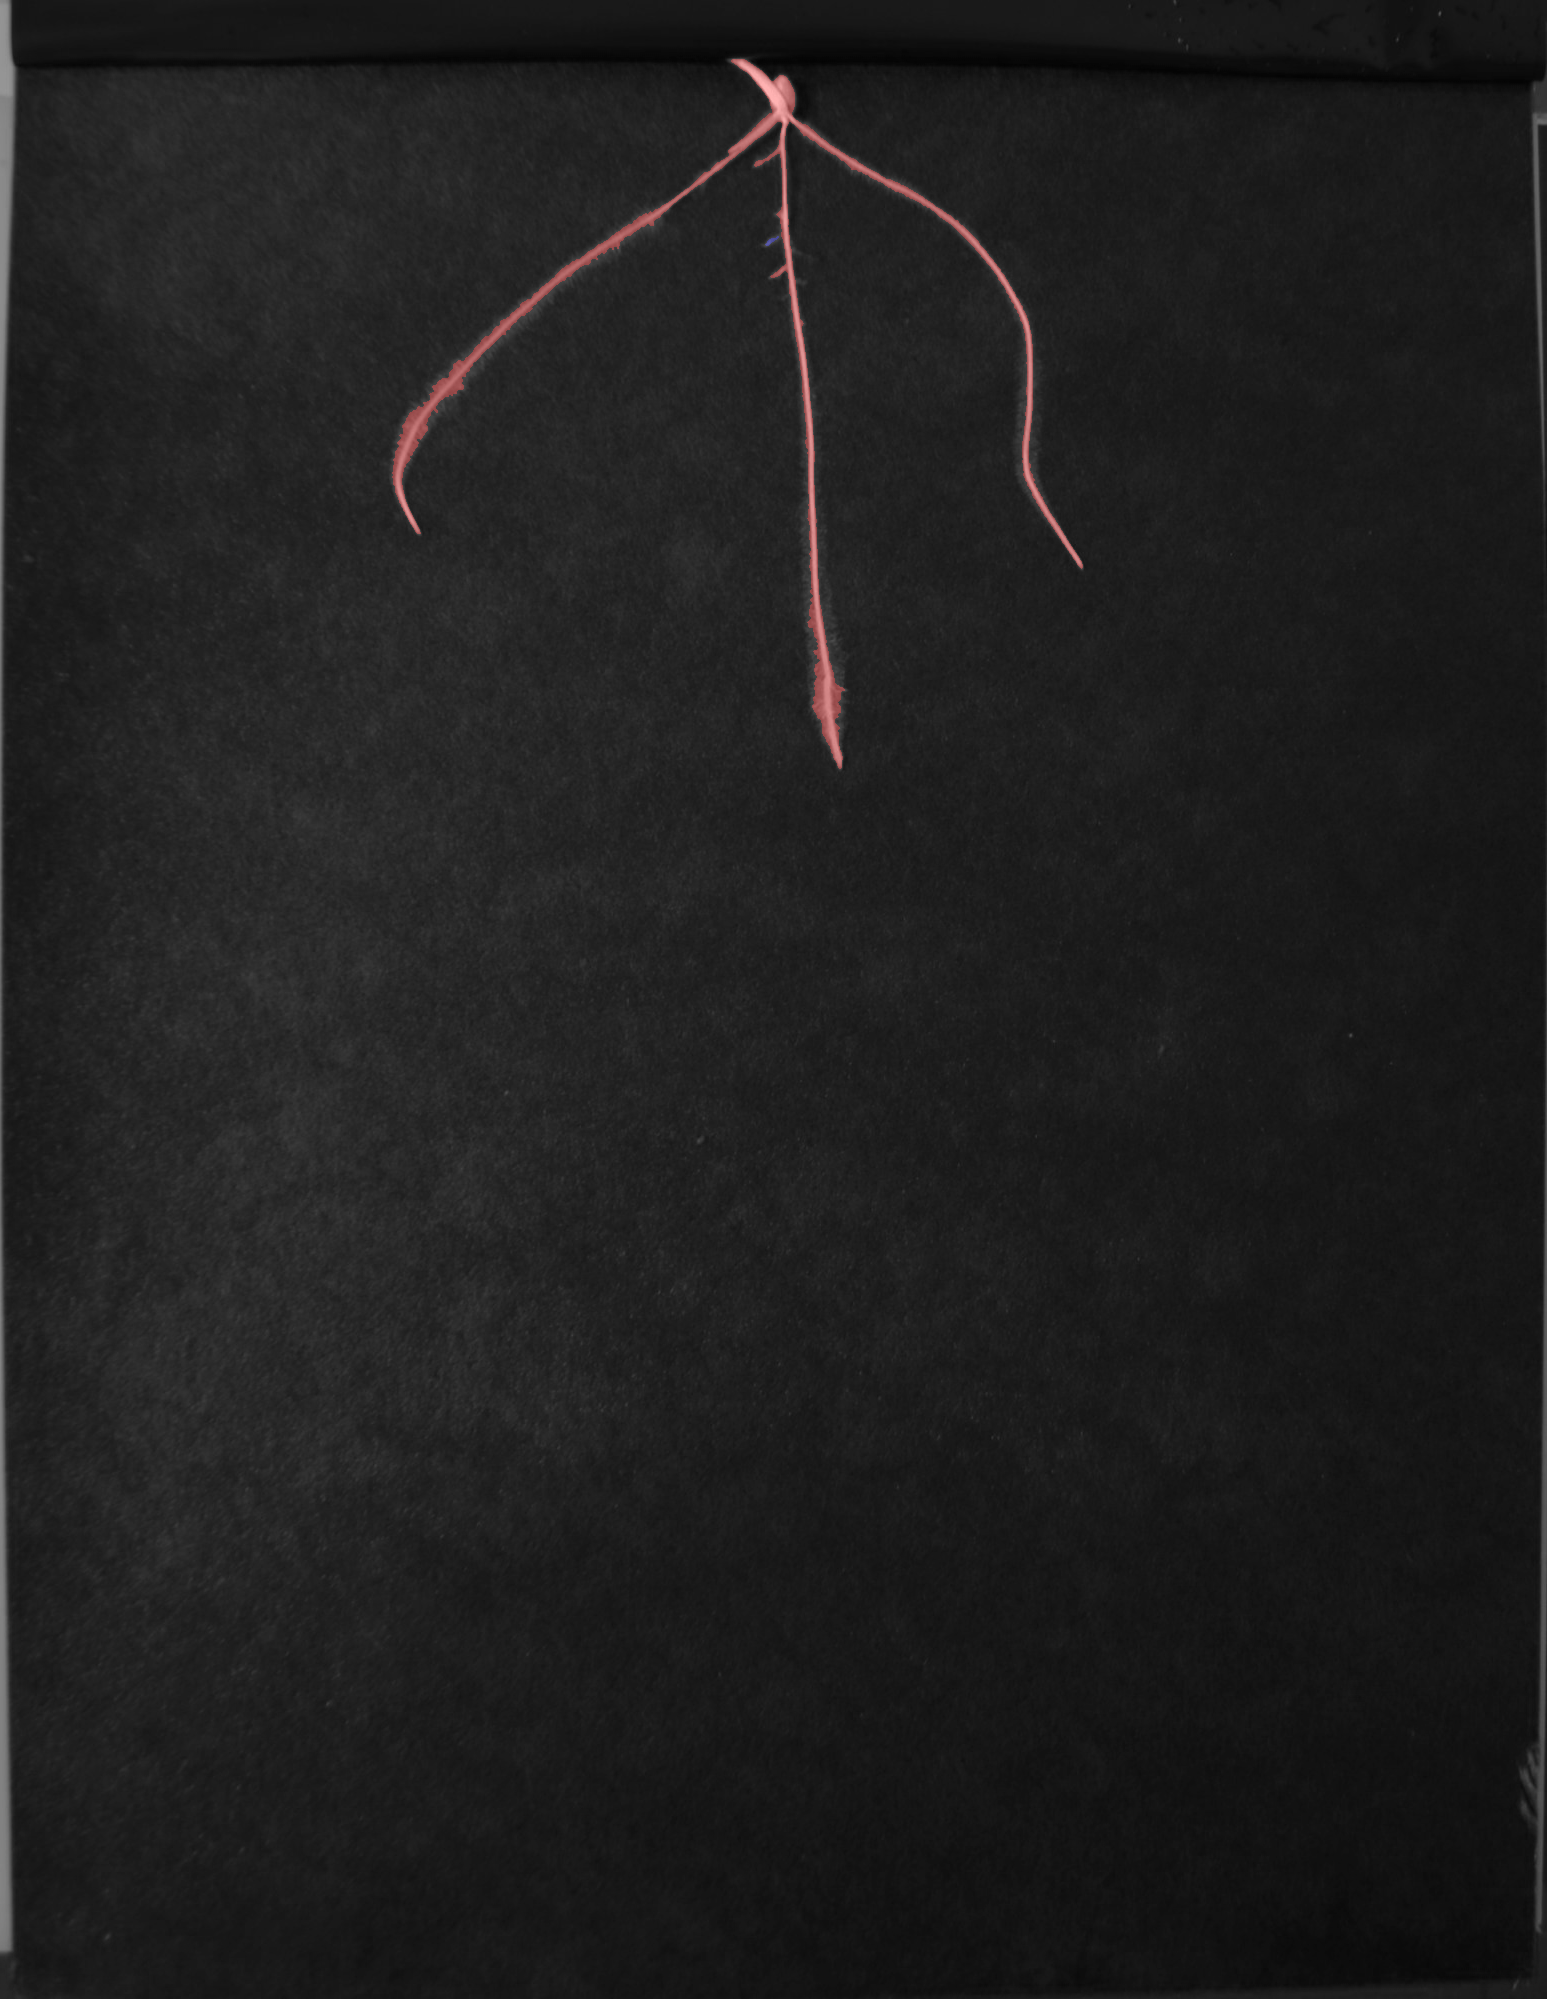

In [12]:
import plotly.express as px
import numpy as np

fig = px.imshow(image_label_overlay)
fig.show()

### Region Props

In [13]:
props = measure.regionprops_table(label_image, final_image, properties = ['label', 'area', 'equivalent_diameter', 'mean_intensity'])
print(props)

{'label': array([1, 2]), 'area': array([17911,    52]), 'equivalent_diameter': array([151.01322288,   8.13685789]), 'mean_intensity': array([1., 1.])}


### Dataframe => CSV

In [14]:
import pandas as pd
df = pd.DataFrame(props)
print(df)

   label   area  equivalent_diameter  mean_intensity
0      1  17911           151.013223             1.0
1      2     52             8.136858             1.0


In [15]:
scale = 0.6
df['area_sq_microns'] = df['area'] * (scale**2) #(scale_x * scale_y) 
df['equivalent_diameter_microns'] = df['equivalent_diameter'] * (scale) #how is this calculated? what to scale this by
print(df)

   label   area  ...  area_sq_microns  equivalent_diameter_microns
0      1  17911  ...          6447.96                    90.607934
1      2     52  ...            18.72                     4.882115

[2 rows x 6 columns]


In [16]:
#import to csv file 
df.to_csv (r'/content/drive/MyDrive/test.csv', index = False, header=True)

print (df)

   label   area  ...  area_sq_microns  equivalent_diameter_microns
0      1  17911  ...          6447.96                    90.607934
1      2     52  ...            18.72                     4.882115

[2 rows x 6 columns]


## File Application

In [17]:
#get rid of .jpg

#/content/drive/MyDrive/Colab_Notebooks/SULI2022/Root_photography/Root_Image_Dataset_1/*.*"



### Root Measurement Function

In [86]:
import skimage.io
import numpy as np
#get rid of the white borders completely and cleanly
from skimage.segmentation import clear_border 
from skimage import measure 
from skimage.measure import label
import pandas as pd
from numpy.core.numeric import False_
import pandas as pd
from pandas._libs.lib import fast_unique_multiple_list_gen
from pathlib import Path


In [153]:
#used for pred image

def measure_pred(filename):

      # read the original image, converting to grayscale on the fly
      img = cv2.imread(filename)

      #extracting red channel
      img = img[:,:,2] 

      pred_name = Path(filename).stem

      # median blur before thresholding
      blurred_img = skimage.filters.median(img)

      # perform automatic thresholding to produce a binary image
      t = skimage.filters.threshold_li(blurred_img)
      binary_mask = blurred_img > t

      #boarder cleaner
      clean_image = clear_border(binary_mask)

      ##"connect disconnected components => dani"

      #image labeling 
      label_image = measure.label(clean_image, connectivity = img.ndim)

      #labels = measure.label(label_image)
      largestCC = label_image == np.argmax(np.bincount(label_image.flat, weights=clean_image.flat))
      
      pred_final_image = largestCC.astype(np.uint8)

      return pred_final_image, pred_name

In [154]:
#used for ground truth

def measure_true(filename):

      # read the original image
      img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)

      true_name = Path(filename).stem

      ##"connect disconnected components => dani"

      #image labeling 
      #label_image = measure.label(img, connectivity = img.ndim)
      #largestCC = label_image == np.argmax(np.bincount(label_image.flat, weights=img.flat))
      #true_final_image = largestCC.astype(np.uint8)

      true_final_image = img.astype(np.uint8)

      return true_final_image, true_name

In [155]:
#from keras import backend as K
from scipy.spatial import distance

##either 3rd function or 2nd function (skilearn or skimage for dice coef instead of keras)

def calculations(pred_final_image, true_final_image, pred_name, true_name):

      #calculating measurements via region props
      pred_props = measure.regionprops_table(pred_final_image, properties = ['area', 'perimeter', 'feret_diameter_max', 'solidity', 'convex_area', 'major_axis_length'])
      pred_props["Name"] = pred_name

      pred_df = pd.DataFrame(pred_props)  
      
      #calculating measurements via region props
      true_props = measure.regionprops_table(true_final_image, properties = ['area', 'perimeter', 'feret_diameter_max', 'solidity', 'convex_area', 'major_axis_length'])
      true_props["Name"] = true_name

      true_df = pd.DataFrame(true_props)  

      #converting to micron scale
      scale = 0.6
      pred_df['area_sq_microns'] = pred_df['area'] * (scale**2) #(scale_x * scale_y) 
      pred_df['perimeter_microns'] = pred_df['perimeter'] * (scale)
      pred_df['feret_diameter_max_microns'] = pred_df['feret_diameter_max'] * (scale)
      pred_df['convex_area_microns'] = pred_df['convex_area'] * (scale)
      pred_df['major_axis_length_microns'] = pred_df['major_axis_length'] * (scale)

      true_df['area_sq_microns'] = true_df['area'] * (scale**2) #(scale_x * scale_y) 
      true_df['perimeter_microns'] = true_df['perimeter'] * (scale)
      true_df['feret_diameter_max_microns'] = true_df['feret_diameter_max'] * (scale)
      true_df['convex_area_microns'] = true_df['convex_area'] * (scale)
      true_df['major_axis_length_microns'] = true_df['major_axis_length'] * (scale)

      #true_f = K.flatten(true_final_image)
      #pred_f = K.flatten(pred_final_image)
      #intersection = K.sum(true_f * pred_f)
      #union = K.sum(true_final_image, axis=[1,2,3]) + K.sum(pred_final_image, axis=[1,2,3])
      #dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)

      #dice = distance.dice(pred_final_image, true_final_image)

      #pred_props["dice_coefficient"] = [dice]    
      #true_props["dice_coefficient"] = [dice]    
      
      return pred_df, true_df

In [156]:
import scipy.sparse
from scipy.spatial import distance
def dice_coef(pred_final_image, true_final_image, smooth=1):
  #true_final_image = true_final_image[0:1999, 155:1600] ##look into cropping ()
  true_f = true_final_image.flatten().astype(dtype=bool)
  #print(true_f)
  #print(type(true_f))
  pred_f = pred_final_image.flatten().astype(dtype=bool)
  #print(pred_f)
  #print(type(pred_f))
  #sA1 = scipy.sparse.csr_matrix(true_f)
  #sA2 = scipy.sparse.csr_matrix(pred_f)
  #np.seterr(invalid= 'ignore')
  dice = distance.dice(true_f, pred_f)
  print(1-dice)

(1999, 1702)
(1999, 1702)
0.7278818711999007


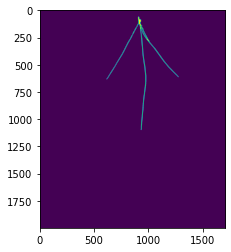

In [157]:
#run the function with one image

pred_filename = "/content/drive/MyDrive/Sample/1_21.jpg"

true_filename = "/content/drive/MyDrive/SampleMask/1_21.jpg"

pred, pred_name = measure_pred(pred_filename)

true, true_name = measure_true(true_filename) #change variable name

pred_df, true_df = calculations(pred, true, pred_name, true_name)

#print(type(pred))

#print(type(true))

print(pred.shape)

print(true.shape)

#plt.imshow(pred)

plt.imshow(true) ##look into this 


dice_coef(pred, true)

pred_df.to_csv (r'/content/drive/MyDrive/pred_testing.csv', index = False, header=True)
true_df.to_csv (r'/content/drive/MyDrive/true_testing.csv', index = False, header=True)

1


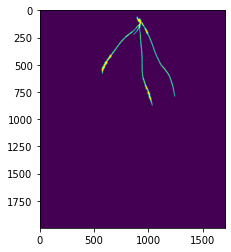

In [49]:
plt.imshow(pred)
print(np.max(pred))

In [117]:
v = np.arange(0,10)>2
flat_v = v.flatten()>1
print(v)
print(flat_v)
dice_coef(v,v)

distance.dice(1,1)

[False False False  True  True  True  True  True  True  True]
[False False False False False False False False False False]
0.0


0.0

In [113]:
print(True >= 1)
False > 1

True


False

## Run Through All Files

In [158]:
#run function on sample dataset 

#avoid storing images 
pred_imgs =[]
pred_nms =[]

true_imgs =[]
true_nms =[]

## one for loop == two (images pred and true file)
## and then processing(calculations)
##append to df 
#end for loop and it will overwrite the old images 

files = glob.glob("/content/drive/MyDrive/Sample/*.jpg")
for filename in files:
    pred_img, pred_name = measure_pred(filename) #==> returns a pred image np array and shortened name
    pred_imgs.append(pred_img) #avoid
    pred_nms.append(pred_name)

files = glob.glob("/content/drive/MyDrive/SampleMask/*.jpg")
for filename in files:
    true_img, true_name = measure_true(filename) #==> returns a true image array
    true_imgs.append(true_img)
    true_nms.append(true_name)

pred_dfs =[]
true_dfs =[]
for p, t, pn, tn in zip(pred_imgs, true_imgs, pred_nms, true_nms):
     #for pn, tn in zip(pred_nms, true_nms):
       pred_df, true_df = calculations(p, t, pn, tn)

       pred_dfs.append(pred_df)

       true_dfs.append(true_df)

       ##1 - distance dice = similarity 
       dice_coef(p,t) #return as value
       
pred_dfs = pd.concat(pred_dfs)
true_dfs = pd.concat(true_dfs)

pred_dfs.to_csv (r'/content/drive/MyDrive/TEST_PRED.csv', index = False, header=True)
true_dfs.to_csv (r'/content/drive/MyDrive/TEST_TRUE.csv', index = False, header=True)

0.7527931167330166
0.7278818711999007
0.7491799142064093
0.7621108918454389


In [ ]:
#run function on sample dataset 
#pred_imgs =[]
#true_imgs =[]

pred_files = glob.glob("/content/drive/MyDrive/Sample/*.*")
for filename in pred_files:

    pred_img = measure_root(filename) #==> returns a pred image array
    #pred_imgs.append(pred_img)


true_files = glob.glob("/content/drive/MyDrive/SampleMask/*.*")
for filename in true_files:

    true_img = measure_roots(filename) #==> returns a true image array
    #true_imgs.append(true_img)
   

pred_df, true_df = calculations(pred_img, true_img)

pred_dfs = pd.concat(pred_df)
true_dfs = pd.concat(true_df)

pred_dfs.to_csv (r'/content/drive/MyDrive/t.csv', index = False, header=True)
true_dfs.to_csv (r'/content/drive/MyDrive/testingMaskt.csv', index = False, header=True)

ValueError: ignored

## Validation Testing for Mask Images



In [ ]:
#run function on sample dataset 
true_dfs =[]
all_files = glob.glob("/content/drive/MyDrive/SampleMask/*.*")
for filename in all_files:
    info = measure_roots(filename)
    true_dfs.append(info)

true_dfs = pd.concat(true_dfs)
true_dfs.to_csv (r'/content/drive/MyDrive/testingMaskt.csv', index = False, header=True)

## Measuring Accuracy of Segmentation

In [ ]:
from keras import backend as K

##either 3rd function or 2nd function (skilearn or skimage for dice coef instead of keras)
def dice_coef(true_dfs, pred_dfs, smooth=1):
  true_dfs_f = K.flatten(true_dfs)
  pred_dfs_f = K.flatten(pred_dfs)
  intersection = K.sum(true_dfs_f * pred_dfs_f)
  return (2. * intersection + smooth)/(K.sum(true_dfs_f) + K.sum(pred_dfs_f) + smooth)


print(dice_coef(true_dfs, pred_dfs))

ValueError: ignored

### Single Mask Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1999, 1702, 3)


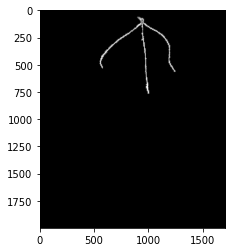

In [ ]:
# read the original image
img = cv2.imread('/content/drive/MyDrive/SampleMask/1_4.jpg')

##redo reading of image

name = Path(filename).stem

#crop image used for labeling
#crop_img = img[0:1999, 155:1702]

#image labeling 
label_image = measure.label(img, connectivity = img.ndim)
plt.imshow(label_image)
np.unique(label_image)
print(img.shape)


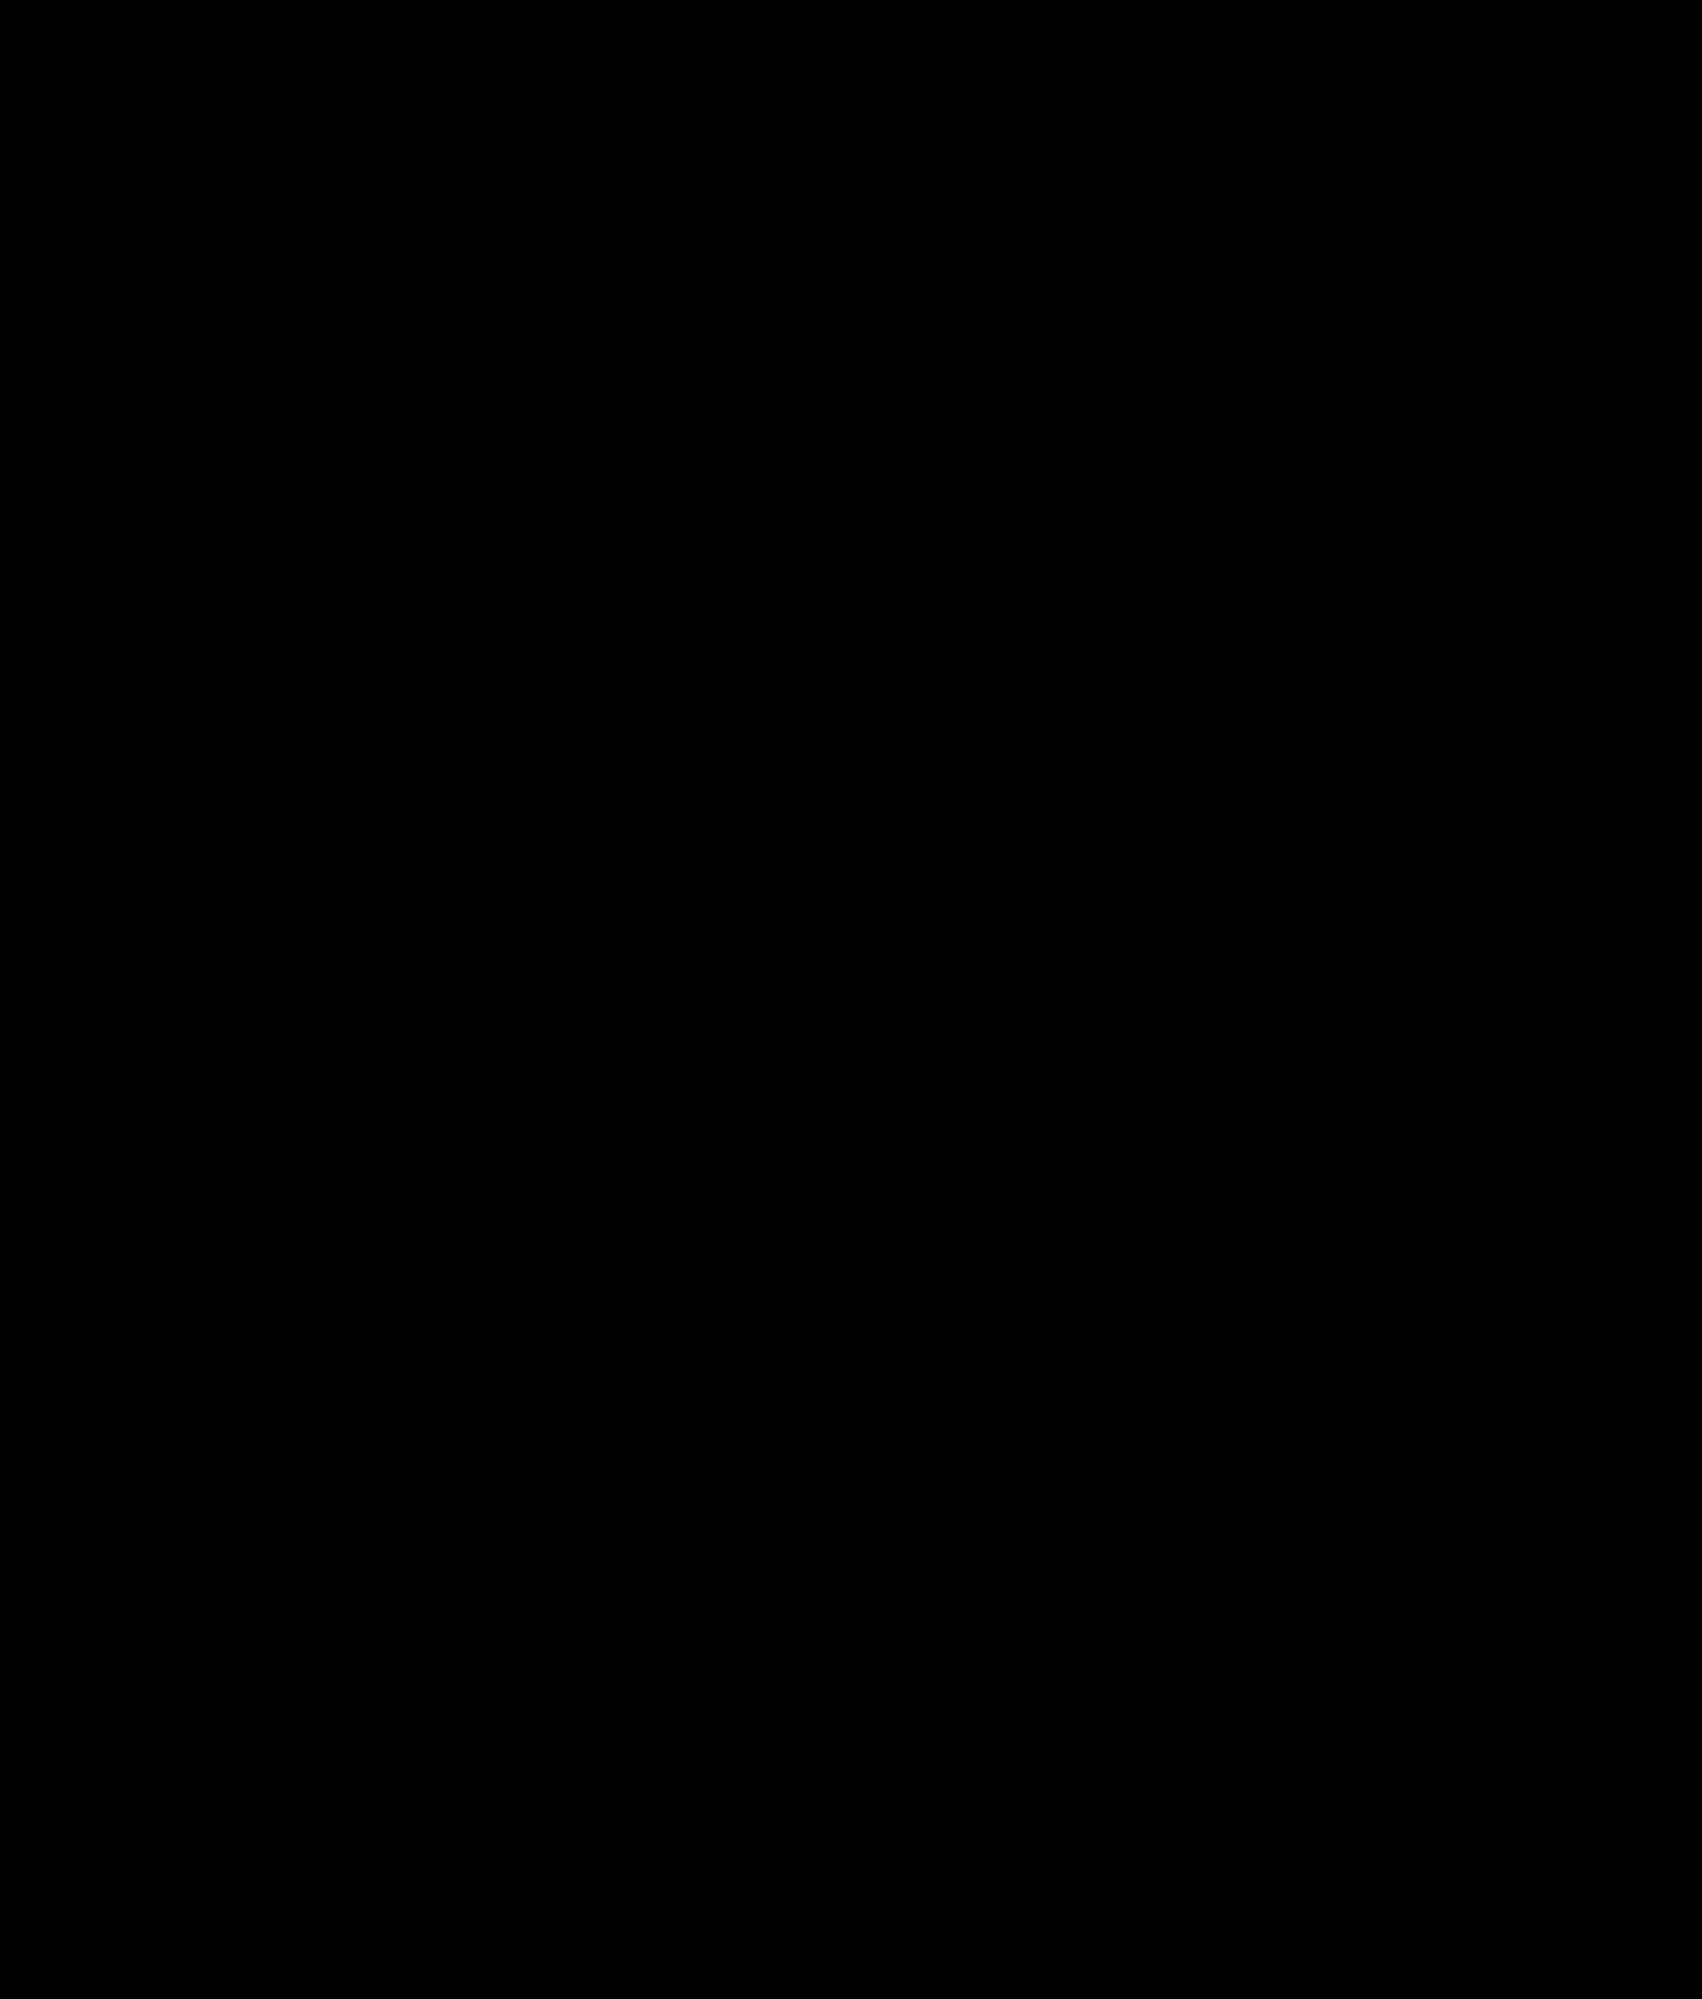

In [ ]:
import plotly.express as px
fig = px.imshow(label_image)
fig.show()

### Measuring Density

In [ ]:
# function for thesholding and density calculation
import skimage.io
#get rid of the white borders completely and cleanly
from skimage.segmentation import clear_border 

def measure_root_mass(name):

      # read the original image, converting to grayscale on the fly
      img = skimage.io.imread(fname=filename, as_gray=True)

      #crop image used for labeling
      crop_img = img[0:1999, 155:1702]

      # median blur before thresholding
      blurred_img = skimage.filters.median(img)

      # perform automatic thresholding to produce a binary image
      t = skimage.filters.threshold_li(blurred_img)
      binary_mask = blurred_img > t

      #boarder cleaner
      clean_image = clear_border(binary_mask)

      # determine root mass ratio
      rootPixels = np.count_nonzero(clean_image)
      w = clean_image.shape[1]
      h = clean_image.shape[0]
      density = rootPixels / (w * h)

      return density

In [ ]:
#run the function with one image

filename = "/content/drive/MyDrive/Colab_Notebooks/SULI2022/Root_photography/Root_Image_Dataset_1/58_8.jpg"

measure_root_mass(filename)

0.0062399002086237

In [ ]:
#run function on entire dataset 
all_files = glob.glob("/content/drive/MyDrive/Colab_Notebooks/SULI2022/Root_photography/Root_Image_Dataset_1/*.*")
for filename in all_files:
    name = os.path.basename(filename)
    density = measure_root_mass(name)
    # output in format suitable for .csv
    print(name, density, sep=",")

41_520.jpg,0.004324430135161587
41_708.jpg,0.004505484234479167
42_584.jpg,0.0029133250526555874
42_685.jpg,0.005343741200800165
41_690.jpg,0.004497842340676801
39_615.jpg,0.007148991652112778
41_414.jpg,0.005062166806082242
39_531.jpg,0.005105078978972447
40_674.jpg,0.002184405951506893
42_566.jpg,0.0034112238257789293
40_651.jpg,0.0033971157141437936
39_628.jpg,0.004523413293015486
40_546.jpg,0.004022281410975759
40_417.jpg,0.002620581736226515
42_575.jpg,0.0051573965596194106
41_633.jpg,0.004426713944516324
40_675.jpg,0.004220382811852459
39_619.jpg,0.0034808826269774134
39_552.jpg,0.005152399936748633
39_538.jpg,0.0027887033998785526
41_528.jpg,0.006237548856684511
39_627.jpg,0.006221971150087382
41_485.jpg,0.006153194105866094
41_687.jpg,0.0051509303417866395
39_389.jpg,0.005838994702991919
40_638.jpg,0.0029812203398996797
42_365.jpg,0.004203629429285736
41_480.jpg,0.007613677579095071
40_622.jpg,0.0037677475635585125
41_489.jpg,0.006725454384066298
35_656.jpg,0.007390005225879685